# Driver Fatigue Detection - Model Training & Comparison

This notebook trains and compares 4 models on the YAWDD dataset:
1. **Custom CNN**
2. **ResNet50**
3. **VGG16**
4. **MobileNetV4**

We use PyTorch for training.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import timm
from tqdm import tqdm
import time
import copy
import splitfolders
import os

# checking avaiability of GPU thorugh cude version for training
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Your source path containing the class folders
input_folder = r'C:\Users\arman\Desktop\FYP_ARMAN\Driver-Fatigue-Detection-Using-Vision-Based-Machine-Learning\EXTRACTED_FEATURES'
# The new destination path for the split data
output_folder = r'C:\Users\arman\Desktop\FYP_ARMAN\Driver-Fatigue-Detection-Using-Vision-Based-Machine-Learning\SPLIT_DATASET'

# Split with a ratio (train=0.8, val=0.2)
# We do not include a test split here as you plan to test on separate videos
splitfolders.ratio(input_folder, 
                   output=output_folder, 
                   seed=42, 
                   ratio=(.8, .2), 
                   move=False) # move=False copies the files to keep originals safe

print(f"Split complete! Data is now in: {output_folder}")

c:\Users\arman\miniconda3\envs\FYP_DFD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version: 2.10.0+cu130
CUDA Available: True
Using device: cuda


Copying files: 25361 files [00:40, 629.18 files/s]

Split complete! Data is now in: C:\Users\arman\Desktop\FYP_ARMAN\Driver-Fatigue-Detection-Using-Vision-Based-Machine-Learning\SPLIT_DATASET


## 1. Data Preparation

In [2]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# --- Point to the NEW Split Dataset folder ---
DATA_DIR = r'C:\Users\arman\Desktop\FYP_ARMAN\Driver-Fatigue-Detection-Using-Vision-Based-Machine-Learning\SPLIT_DATASET'

# --- Match the lowercase folder names created by splitfolders ---
MODES = ['train', 'val'] 
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
        # Redundant Resize removed: frames are already 224x224
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load Datasets using lowercase modes
image_datasets = {
    x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
    for x in MODES
}

# Create Dataloaders
dataloaders = {
    x: DataLoader(
        image_datasets[x], 
        batch_size=BATCH_SIZE, 
        shuffle=(x == 'train'), 
        num_workers=2,
        pin_memory=True 
    )
    for x in MODES
}

dataset_sizes = {x: len(image_datasets[x]) for x in MODES}
class_names = image_datasets['train'].classes

print("-" * 30)
print(f"Success! Data loaded from: {DATA_DIR}")
print(f"Classes found: {class_names}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")
print("-" * 30)

------------------------------
Success! Data loaded from: C:\Users\arman\Desktop\FYP_ARMAN\Driver-Fatigue-Detection-Using-Vision-Based-Machine-Learning\SPLIT_DATASET
Classes found: ['Microsleep', 'Normal', 'Talking', 'Yawning']
Training samples: 20287
Validation samples: 5074
------------------------------


## 2. Define Models

In [3]:
import torch
import torch.nn as nn
from torchvision import models
import timm

def get_model(model_name, num_classes=4, pretrained=True):
    model = None
    
    if model_name == 'CNN':
        # Custom CNN architecture for 224x224 images
        class CustomCNN(nn.Module):
            def __init__(self, num_classes):
                super(CustomCNN, self).__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2), # Output: 112x112
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2), # Output: 56x56
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)  # Output: 28x28
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(128 * 28 * 28, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                x = self.classifier(x)
                return x
        
        model = CustomCNN(num_classes)

    elif model_name == 'ResNet50':
        # Load pre-trained ResNet50 and modify the final fully connected layer
        model = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'VGG16':
        # Load pre-trained VGG16 and modify the final classifier layer
        model = models.vgg16(weights='IMAGENET1K_V1' if pretrained else None)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'MobileNetV4':
        # Using the 'timm' library for MobileNetV4
        try:
            # Using 'mobilenetv4_conv_medium' as a balanced variant for FYP
            model = timm.create_model('mobilenetv4_conv_medium.e15_in1k', 
                                      pretrained=pretrained, 
                                      num_classes=num_classes)
        except Exception as e:
            print(f"MobileNetV4 variant not found. Falling back to MobileNetV3 Large: {e}")
            model = models.mobilenet_v3_large(weights='IMAGENET1K_V1' if pretrained else None)
            num_ftrs = model.classifier[3].in_features
            model.classifier[3] = nn.Linear(num_ftrs, num_classes)

    return model

# Initialize models and move them to device (GPU/CPU)
num_classes = 4 # Updated to match your 4 labels
models_dict = {}

for name in ['CNN', 'ResNet50', 'VGG16', 'MobileNetV4']:
    models_dict[name] = get_model(name, num_classes=num_classes).to(device)
    print(f"Initialized {name} on {device}")

Initialized CNN on cuda
Initialized ResNet50 on cuda
Initialized VGG16 on cuda
MobileNetV4 variant not found. Falling back to MobileNetV3 Large: Invalid pretrained tag (e15_in1k) for mobilenetv4_conv_medium.
Initialized MobileNetV4 on cuda


## 3. Training Loop


STAGING TRAINING: CNN


C:\Users\arman\AppData\Local\Temp\ipykernel_4864\948601669.py:82: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 0/19
----------


Train Phase:   0%|          | 0/634 [00:00<?, ?it/s]C:\Users\arman\AppData\Local\Temp\ipykernel_4864\948601669.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(phase == 'train')):
Train Phase: 100%|██████████| 634/634 [04:22<00:00,  2.42it/s]


Train Loss: 0.9204 Acc: 0.6236


Val Phase: 100%|██████████| 159/159 [00:43<00:00,  3.63it/s]


Val Loss: 0.8076 Acc: 0.6350

Epoch 1/19
----------


Train Phase: 100%|██████████| 634/634 [04:25<00:00,  2.39it/s]


Train Loss: 0.7467 Acc: 0.6724


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.70it/s]


Val Loss: 0.5514 Acc: 0.7816

Epoch 2/19
----------


Train Phase: 100%|██████████| 634/634 [04:13<00:00,  2.50it/s]


Train Loss: 0.4759 Acc: 0.8149


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.74it/s]


Val Loss: 0.3083 Acc: 0.8857

Epoch 3/19
----------


Train Phase: 100%|██████████| 634/634 [04:13<00:00,  2.50it/s]


Train Loss: 0.2999 Acc: 0.8923


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.72it/s]


Val Loss: 0.1889 Acc: 0.9365

Epoch 4/19
----------


Train Phase: 100%|██████████| 634/634 [04:13<00:00,  2.50it/s]


Train Loss: 0.1986 Acc: 0.9308


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.71it/s]


Val Loss: 0.1166 Acc: 0.9588

Epoch 5/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.1566 Acc: 0.9481


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.74it/s]


Val Loss: 0.0951 Acc: 0.9669

Epoch 6/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.1278 Acc: 0.9574


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.75it/s]


Val Loss: 0.0830 Acc: 0.9704

Epoch 7/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.1114 Acc: 0.9638


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.74it/s]


Val Loss: 0.0597 Acc: 0.9785

Epoch 8/19
----------


Train Phase: 100%|██████████| 634/634 [04:13<00:00,  2.50it/s]


Train Loss: 0.1008 Acc: 0.9659


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.74it/s]


Val Loss: 0.0700 Acc: 0.9771

Epoch 9/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.0998 Acc: 0.9676


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.71it/s]


Val Loss: 0.0590 Acc: 0.9807

Epoch 10/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.0852 Acc: 0.9705


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.75it/s]


Val Loss: 0.0750 Acc: 0.9736

Epoch 11/19
----------


Train Phase: 100%|██████████| 634/634 [04:13<00:00,  2.51it/s]


Train Loss: 0.0881 Acc: 0.9720


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.71it/s]


Val Loss: 0.0744 Acc: 0.9762

Epoch 12/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.0834 Acc: 0.9735


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.71it/s]


Val Loss: 0.1097 Acc: 0.9677

Epoch 13/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.0823 Acc: 0.9739


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.71it/s]


Val Loss: 0.0474 Acc: 0.9866

Epoch 14/19
----------


Train Phase: 100%|██████████| 634/634 [04:11<00:00,  2.52it/s]


Train Loss: 0.0781 Acc: 0.9759


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.72it/s]


Val Loss: 0.0516 Acc: 0.9831

Epoch 15/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.0704 Acc: 0.9772


Val Phase: 100%|██████████| 159/159 [00:43<00:00,  3.67it/s]


Val Loss: 0.0511 Acc: 0.9848

Epoch 16/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.0803 Acc: 0.9758


Val Phase: 100%|██████████| 159/159 [00:43<00:00,  3.68it/s]


Val Loss: 0.0552 Acc: 0.9831

Epoch 17/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.0701 Acc: 0.9775


Val Phase: 100%|██████████| 159/159 [00:43<00:00,  3.70it/s]


Val Loss: 0.0421 Acc: 0.9864

Epoch 18/19
----------


Train Phase: 100%|██████████| 634/634 [04:12<00:00,  2.51it/s]


Train Loss: 0.0684 Acc: 0.9779


Val Phase: 100%|██████████| 159/159 [00:42<00:00,  3.72it/s]


Val Loss: 0.0468 Acc: 0.9868

Epoch 19/19
----------


Train Phase: 100%|██████████| 634/634 [04:13<00:00,  2.50it/s]


Train Loss: 0.0702 Acc: 0.9778


Val Phase: 100%|██████████| 159/159 [00:41<00:00,  3.81it/s]


Val Loss: 0.0423 Acc: 0.9876

Training complete in 98m 55s
Best val Acc: 0.987584
Saved best weights for CNN.

STAGING TRAINING: ResNet50
Epoch 0/19
----------


Train Phase: 100%|██████████| 634/634 [19:49<00:00,  1.88s/it]


Train Loss: 0.1869 Acc: 0.9365


Val Phase: 100%|██████████| 159/159 [02:12<00:00,  1.20it/s]


Val Loss: 0.3239 Acc: 0.8963

Epoch 1/19
----------


Train Phase: 100%|██████████| 634/634 [17:53<00:00,  1.69s/it]


Train Loss: 0.1194 Acc: 0.9646


Val Phase: 100%|██████████| 159/159 [01:20<00:00,  1.98it/s]


Val Loss: 0.2969 Acc: 0.9068

Epoch 2/19
----------


Train Phase: 100%|██████████| 634/634 [03:20<00:00,  3.16it/s]


Train Loss: 0.0972 Acc: 0.9713


Val Phase: 100%|██████████| 159/159 [01:28<00:00,  1.80it/s]


Val Loss: 0.0935 Acc: 0.9746

Epoch 3/19
----------


Train Phase: 100%|██████████| 634/634 [04:11<00:00,  2.52it/s]


Train Loss: 0.0871 Acc: 0.9737


Val Phase: 100%|██████████| 159/159 [01:08<00:00,  2.33it/s]


Val Loss: 0.0824 Acc: 0.9752

Epoch 4/19
----------


Train Phase: 100%|██████████| 634/634 [04:32<00:00,  2.33it/s]


Train Loss: 0.0825 Acc: 0.9775


Val Phase: 100%|██████████| 159/159 [01:41<00:00,  1.57it/s]


Val Loss: 0.0843 Acc: 0.9795

Epoch 5/19
----------


Train Phase: 100%|██████████| 634/634 [04:19<00:00,  2.44it/s]


Train Loss: 0.0818 Acc: 0.9736


Val Phase: 100%|██████████| 159/159 [01:07<00:00,  2.36it/s]


Val Loss: 0.1823 Acc: 0.9417

Epoch 6/19
----------


Train Phase: 100%|██████████| 634/634 [04:19<00:00,  2.44it/s]


Train Loss: 0.0762 Acc: 0.9776


Val Phase: 100%|██████████| 159/159 [01:07<00:00,  2.37it/s]


Val Loss: 0.0525 Acc: 0.9862

Epoch 7/19
----------


Train Phase: 100%|██████████| 634/634 [04:18<00:00,  2.45it/s]


Train Loss: 0.0703 Acc: 0.9803


Val Phase: 100%|██████████| 159/159 [01:39<00:00,  1.60it/s]


Val Loss: 0.0578 Acc: 0.9817

Epoch 8/19
----------


Train Phase: 100%|██████████| 634/634 [04:18<00:00,  2.46it/s]


Train Loss: 0.0681 Acc: 0.9806


Val Phase: 100%|██████████| 159/159 [01:39<00:00,  1.61it/s]


Val Loss: 0.0534 Acc: 0.9836

Epoch 9/19
----------


Train Phase: 100%|██████████| 634/634 [04:18<00:00,  2.46it/s]


Train Loss: 0.0680 Acc: 0.9802


Val Phase: 100%|██████████| 159/159 [01:38<00:00,  1.61it/s]


Val Loss: 0.0661 Acc: 0.9801

Epoch 10/19
----------


Train Phase: 100%|██████████| 634/634 [04:17<00:00,  2.46it/s]


Train Loss: 0.0627 Acc: 0.9828


Val Phase: 100%|██████████| 159/159 [01:41<00:00,  1.56it/s]


Val Loss: 0.0426 Acc: 0.9862

Epoch 11/19
----------


Train Phase: 100%|██████████| 634/634 [04:22<00:00,  2.42it/s]


Train Loss: 0.0617 Acc: 0.9817


Val Phase: 100%|██████████| 159/159 [01:39<00:00,  1.60it/s]


Val Loss: 0.0848 Acc: 0.9756

Epoch 12/19
----------


Train Phase: 100%|██████████| 634/634 [04:17<00:00,  2.46it/s]


Train Loss: 0.0597 Acc: 0.9834


Val Phase: 100%|██████████| 159/159 [01:39<00:00,  1.60it/s]


Val Loss: 0.0461 Acc: 0.9884

Epoch 13/19
----------


Train Phase: 100%|██████████| 634/634 [04:15<00:00,  2.48it/s]


Train Loss: 0.0551 Acc: 0.9839


Val Phase: 100%|██████████| 159/159 [01:07<00:00,  2.35it/s]


Val Loss: 0.0494 Acc: 0.9840

Epoch 14/19
----------


Train Phase: 100%|██████████| 634/634 [04:15<00:00,  2.48it/s]


Train Loss: 0.0589 Acc: 0.9823


Val Phase: 100%|██████████| 159/159 [01:07<00:00,  2.36it/s]


Val Loss: 0.0566 Acc: 0.9789

Epoch 15/19
----------


Train Phase: 100%|██████████| 634/634 [04:15<00:00,  2.48it/s]


Train Loss: 0.0371 Acc: 0.9883


Val Phase: 100%|██████████| 159/159 [01:07<00:00,  2.35it/s]


Val Loss: 0.0241 Acc: 0.9921

Epoch 16/19
----------


Train Phase: 100%|██████████| 634/634 [04:27<00:00,  2.37it/s]


Train Loss: 0.0333 Acc: 0.9903


Val Phase: 100%|██████████| 159/159 [01:39<00:00,  1.60it/s]


Val Loss: 0.0307 Acc: 0.9892

Epoch 17/19
----------


Train Phase: 100%|██████████| 634/634 [04:27<00:00,  2.37it/s]


Train Loss: 0.0324 Acc: 0.9910


Val Phase: 100%|██████████| 159/159 [01:39<00:00,  1.60it/s]


Val Loss: 0.0238 Acc: 0.9923

Epoch 18/19
----------


Train Phase: 100%|██████████| 634/634 [04:19<00:00,  2.44it/s]


Train Loss: 0.0366 Acc: 0.9893


Val Phase: 100%|██████████| 159/159 [01:10<00:00,  2.25it/s]


Val Loss: 0.0336 Acc: 0.9899

Epoch 19/19
----------


Train Phase: 100%|██████████| 634/634 [04:19<00:00,  2.44it/s]


Train Loss: 0.0279 Acc: 0.9916


Val Phase: 100%|██████████| 159/159 [01:10<00:00,  2.24it/s]


Val Loss: 0.0255 Acc: 0.9927

Training complete in 143m 57s
Best val Acc: 0.992708
Saved best weights for ResNet50.

STAGING TRAINING: MobileNetV4
MobileNetV4 variant error: Invalid pretrained tag (e15_in1k) for mobilenetv4_conv_medium.. Falling back to MobileNetV3 Large.
Epoch 0/19
----------


Train Phase: 100%|██████████| 634/634 [01:57<00:00,  5.42it/s]


Train Loss: 0.1381 Acc: 0.9538


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.15it/s]


Val Loss: 0.0795 Acc: 0.9742

Epoch 1/19
----------


Train Phase: 100%|██████████| 634/634 [01:34<00:00,  6.69it/s]


Train Loss: 0.0727 Acc: 0.9770


Val Phase: 100%|██████████| 159/159 [00:31<00:00,  5.13it/s]


Val Loss: 0.0481 Acc: 0.9850

Epoch 2/19
----------


Train Phase: 100%|██████████| 634/634 [01:34<00:00,  6.72it/s]


Train Loss: 0.0636 Acc: 0.9800


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.23it/s]


Val Loss: 0.0725 Acc: 0.9748

Epoch 3/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.65it/s]


Train Loss: 0.0557 Acc: 0.9830


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.16it/s]


Val Loss: 0.0471 Acc: 0.9868

Epoch 4/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.66it/s]


Train Loss: 0.0572 Acc: 0.9828


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.19it/s]


Val Loss: 0.0726 Acc: 0.9764

Epoch 5/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.63it/s]


Train Loss: 0.0512 Acc: 0.9834


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.16it/s]


Val Loss: 0.0813 Acc: 0.9795

Epoch 6/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.65it/s]


Train Loss: 0.0513 Acc: 0.9843


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.19it/s]


Val Loss: 0.0501 Acc: 0.9866

Epoch 7/19
----------


Train Phase: 100%|██████████| 634/634 [01:34<00:00,  6.68it/s]


Train Loss: 0.0420 Acc: 0.9872


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.15it/s]


Val Loss: 0.0524 Acc: 0.9860

Epoch 8/19
----------


Train Phase: 100%|██████████| 634/634 [01:34<00:00,  6.68it/s]


Train Loss: 0.0262 Acc: 0.9919


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.15it/s]


Val Loss: 0.0222 Acc: 0.9929

Epoch 9/19
----------


Train Phase: 100%|██████████| 634/634 [01:34<00:00,  6.70it/s]


Train Loss: 0.0278 Acc: 0.9918


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.19it/s]


Val Loss: 0.0224 Acc: 0.9931

Epoch 10/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.64it/s]


Train Loss: 0.0268 Acc: 0.9927


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.19it/s]


Val Loss: 0.0230 Acc: 0.9937

Epoch 11/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.65it/s]


Train Loss: 0.0238 Acc: 0.9924


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.20it/s]


Val Loss: 0.0168 Acc: 0.9951

Epoch 12/19
----------


Train Phase: 100%|██████████| 634/634 [01:36<00:00,  6.59it/s]


Train Loss: 0.0247 Acc: 0.9932


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.18it/s]


Val Loss: 0.0204 Acc: 0.9939

Epoch 13/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.65it/s]


Train Loss: 0.0244 Acc: 0.9926


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.17it/s]


Val Loss: 0.0183 Acc: 0.9943

Epoch 14/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.65it/s]


Train Loss: 0.0262 Acc: 0.9920


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.20it/s]


Val Loss: 0.0225 Acc: 0.9945

Epoch 15/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.63it/s]


Train Loss: 0.0245 Acc: 0.9919


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.20it/s]


Val Loss: 0.0320 Acc: 0.9909

Epoch 16/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.65it/s]


Train Loss: 0.0147 Acc: 0.9949


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.15it/s]


Val Loss: 0.0125 Acc: 0.9959

Epoch 17/19
----------


Train Phase: 100%|██████████| 634/634 [01:34<00:00,  6.68it/s]


Train Loss: 0.0138 Acc: 0.9958


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.22it/s]


Val Loss: 0.0169 Acc: 0.9943

Epoch 18/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.66it/s]


Train Loss: 0.0141 Acc: 0.9960


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.20it/s]


Val Loss: 0.0139 Acc: 0.9951

Epoch 19/19
----------


Train Phase: 100%|██████████| 634/634 [01:35<00:00,  6.64it/s]


Train Loss: 0.0119 Acc: 0.9962


Val Phase: 100%|██████████| 159/159 [00:30<00:00,  5.18it/s]


Val Loss: 0.0190 Acc: 0.9947

Training complete in 42m 21s
Best val Acc: 0.995861
Saved best weights for MobileNetV4.

STAGING TRAINING: VGG16
Epoch 0/19
----------


Train Phase: 100%|██████████| 634/634 [24:08<00:00,  2.28s/it]


Train Loss: 1.1523 Acc: 0.5933


Val Phase: 100%|██████████| 159/159 [05:13<00:00,  1.97s/it]


Val Loss: 0.9088 Acc: 0.6110

Epoch 1/19
----------


Train Phase: 100%|██████████| 634/634 [25:21<00:00,  2.40s/it]


Train Loss: 0.8695 Acc: 0.6267


Val Phase: 100%|██████████| 159/159 [05:07<00:00,  1.93s/it]


Val Loss: 0.8488 Acc: 0.6299

Epoch 2/19
----------


Train Phase: 100%|██████████| 634/634 [24:37<00:00,  2.33s/it]


Train Loss: 0.7322 Acc: 0.7023


Val Phase: 100%|██████████| 159/159 [05:11<00:00,  1.96s/it]


Val Loss: 0.4471 Acc: 0.8195

Epoch 3/19
----------


Train Phase: 100%|██████████| 634/634 [25:15<00:00,  2.39s/it]


Train Loss: 0.4873 Acc: 0.8319


Val Phase: 100%|██████████| 159/159 [05:07<00:00,  1.93s/it]


Val Loss: 0.1659 Acc: 0.9462

Epoch 4/19
----------


Train Phase: 100%|██████████| 634/634 [24:21<00:00,  2.30s/it]


Train Loss: 0.1832 Acc: 0.9443


Val Phase: 100%|██████████| 159/159 [05:08<00:00,  1.94s/it]


Val Loss: 0.2819 Acc: 0.8989

Epoch 5/19
----------


Train Phase: 100%|██████████| 634/634 [24:16<00:00,  2.30s/it]


Train Loss: 0.1540 Acc: 0.9539


Val Phase: 100%|██████████| 159/159 [05:09<00:00,  1.95s/it]


Val Loss: 0.1279 Acc: 0.9639

Epoch 6/19
----------


Train Phase: 100%|██████████| 634/634 [24:18<00:00,  2.30s/it]


Train Loss: 0.1310 Acc: 0.9643


Val Phase: 100%|██████████| 159/159 [05:11<00:00,  1.96s/it]


Val Loss: 0.0725 Acc: 0.9836

Epoch 7/19
----------


Train Phase: 100%|██████████| 634/634 [25:18<00:00,  2.39s/it]


Train Loss: 0.1725 Acc: 0.9573


Val Phase: 100%|██████████| 159/159 [05:09<00:00,  1.94s/it]


Val Loss: 0.0653 Acc: 0.9831

Epoch 8/19
----------


Train Phase: 100%|██████████| 634/634 [25:16<00:00,  2.39s/it]


Train Loss: 0.0869 Acc: 0.9792


Val Phase: 100%|██████████| 159/159 [05:09<00:00,  1.94s/it]


Val Loss: 0.0567 Acc: 0.9872

Epoch 9/19
----------


Train Phase: 100%|██████████| 634/634 [24:27<00:00,  2.31s/it]


Train Loss: 0.0842 Acc: 0.9782


Val Phase: 100%|██████████| 159/159 [05:10<00:00,  1.95s/it]


Val Loss: 0.0605 Acc: 0.9862

Epoch 10/19
----------


Train Phase: 100%|██████████| 634/634 [24:40<00:00,  2.33s/it]


Train Loss: 0.0874 Acc: 0.9777


Val Phase: 100%|██████████| 159/159 [05:11<00:00,  1.96s/it]


Val Loss: 0.0720 Acc: 0.9823

Epoch 11/19
----------


Train Phase: 100%|██████████| 634/634 [24:35<00:00,  2.33s/it]


Train Loss: 0.0991 Acc: 0.9745


Val Phase: 100%|██████████| 159/159 [05:11<00:00,  1.96s/it]


Val Loss: 0.0402 Acc: 0.9874

Epoch 12/19
----------


Train Phase: 100%|██████████| 634/634 [23:54<00:00,  2.26s/it]


Train Loss: 0.0716 Acc: 0.9819


Val Phase: 100%|██████████| 159/159 [05:22<00:00,  2.03s/it]


Val Loss: 0.0596 Acc: 0.9872

Epoch 13/19
----------


Train Phase: 100%|██████████| 634/634 [25:49<00:00,  2.44s/it]


Train Loss: 0.1091 Acc: 0.9732


Val Phase: 100%|██████████| 159/159 [05:24<00:00,  2.04s/it]


Val Loss: 0.0741 Acc: 0.9783

Epoch 14/19
----------


Train Phase: 100%|██████████| 634/634 [23:39<00:00,  2.24s/it]


Train Loss: 0.0802 Acc: 0.9808


Val Phase: 100%|██████████| 159/159 [04:45<00:00,  1.80s/it]


Val Loss: 0.0631 Acc: 0.9827

Epoch 15/19
----------


Train Phase: 100%|██████████| 634/634 [22:32<00:00,  2.13s/it]


Train Loss: 0.0626 Acc: 0.9841


Val Phase: 100%|██████████| 159/159 [04:49<00:00,  1.82s/it]


Val Loss: 0.0521 Acc: 0.9878

Epoch 16/19
----------


Train Phase: 100%|██████████| 634/634 [21:59<00:00,  2.08s/it]


Train Loss: 0.0458 Acc: 0.9883


Val Phase: 100%|██████████| 159/159 [04:48<00:00,  1.82s/it]


Val Loss: 0.0417 Acc: 0.9888

Early stopping triggered at epoch 17. Restoring best weights.
Training complete in 501m 46s
Best val Acc: 0.988766
Saved best weights for VGG16.


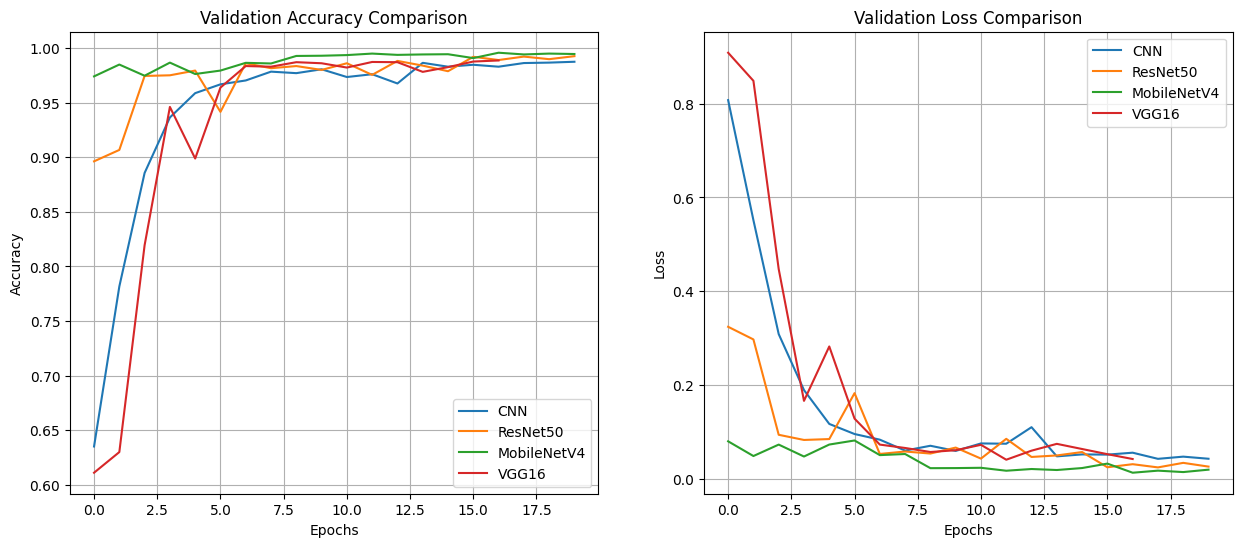


FINAL MODEL COMPARISON SUMMARY
Model Name      | Best Val Acc
------------------------------
CNN             | 0.9876
ResNet50        | 0.9927
MobileNetV4     | 0.9959
VGG16           | 0.9888


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.cuda.amp import GradScaler, autocast  # For Faster Training
import timm
import copy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# --- 1. MODEL DEFINITION FUNCTION ---
def get_model(model_name, num_classes=4, pretrained=True):
    model = None
    
    if model_name == 'CNN':
        class CustomCNN(nn.Module):
            def __init__(self, num_classes):
                super(CustomCNN, self).__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2), # 112x112
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2), # 56x56
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)  # 28x28
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(128 * 28 * 28, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                x = self.classifier(x)
                return x
        model = CustomCNN(num_classes)

    elif model_name == 'ResNet50':
        model = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'VGG16':
        model = models.vgg16(weights='IMAGENET1K_V1' if pretrained else None)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'MobileNetV4':
        try:
            model = timm.create_model('mobilenetv4_conv_medium.e15_in1k', pretrained=pretrained, num_classes=num_classes)
        except Exception as e:
            print(f"MobileNetV4 variant error: {e}. Falling back to MobileNetV3 Large.")
            model = models.mobilenet_v3_large(weights='IMAGENET1K_V1' if pretrained else None)
            num_ftrs = model.classifier[3].in_features
            model.classifier[3] = nn.Linear(num_ftrs, num_classes)

    return model

# --- 2. HIGH-EFFICIENCY TRAINING FUNCTION ---
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, 
                scheduler=None, num_epochs=25, patience=7):
    since = time.time()
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    # MIXED PRECISION: Initialize GradScaler for faster training
    scaler = GradScaler()

    for epoch in range(num_epochs):
        if early_stop:
            print(f"Early stopping triggered at epoch {epoch}. Restoring best weights.")
            break
            
        print(f'Epoch {epoch}/{num_epochs - 1}\n' + '-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Phase"):
                # OPTIMIZATION: Use non_blocking for faster transfer
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                # OPTIMIZATION: set_to_none is faster than zero_grad
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == 'train'):
                    # MIXED PRECISION: autocast enables FP16 speedup
                    with autocast(enabled=(phase == 'train')):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        # MIXED PRECISION: Backpropagate with scaled loss
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                
                # EARLY STOPPING logic
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    epochs_no_improve = 0 
                else:
                    epochs_no_improve += 1
                
                if epochs_no_improve >= patience:
                    early_stop = True

                if scheduler is not None:
                    scheduler.step(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# --- 3. MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    # Settings
    NUM_EPOCHS = 20
    PATIENCE = 5
    LEARNING_RATE = 0.001
    model_names = ['CNN', 'ResNet50', 'MobileNetV4', 'VGG16'] # Fast to slow order
    
    all_histories = {}
    trained_models = {}

    for name in model_names:
        print(f"\n{'='*50}\nSTAGING TRAINING: {name}\n{'='*50}")
        
        # Initialize model
        model = get_model(name, num_classes=len(class_names), pretrained=True).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

        # Training
        best_model, history = train_model(
            model, dataloaders, dataset_sizes, criterion, optimizer, device,
            scheduler=scheduler, num_epochs=NUM_EPOCHS, patience=PATIENCE
        )
        
        all_histories[name] = history
        trained_models[name] = best_model
        
        # Save weights
        torch.save(best_model.state_dict(), f"{name}.pth")
        print(f"Saved best weights for {name}.")

    # --- 4. FINAL VISUALIZATION ---
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    for name in model_names:
        plt.plot(all_histories[name]['val_acc'], label=f'{name}')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    for name in model_names:
        plt.plot(all_histories[name]['val_loss'], label=f'{name}')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.show()

    print(f"\n{'='*40}\nFINAL MODEL COMPARISON SUMMARY\n{'='*40}")
    print(f"{'Model Name':<15} | {'Best Val Acc':<12}\n" + "-" * 30)
    for name in model_names:
        print(f"{name:<15} | {max(all_histories[name]['val_acc']):.4f}")